# Transfomer (New Version)

### Importing necessary libraries

In [18]:
import time
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import math

### Load and preprocess the data

In [19]:
# Load the data and parse the 'Timestamp' column explicitly
data = pd.read_csv(
    '/Users/casper/Documents/GitHub/p9-energy/Examples/test-data/maj2023_2024.csv', sep=';')
data['Timestamp'] = pd.to_datetime(
    data['Timestamp'], format='%d.%m.%Y %H.%M.%S')

# Feature engineering: Add time-related features (hour, day, month)
data['Hour'] = data['Timestamp'].dt.hour
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek
data['Month'] = data['Timestamp'].dt.month

# Split data into training (2023) and evaluation (2024) sets
train_data = data[data['Timestamp'].dt.year == 2023]
eval_data = data[data['Timestamp'].dt.year == 2024]

# Convert usage to numpy arrays
train_usage = train_data['Usage'].values.reshape(-1, 1)
eval_usage = eval_data['Usage'].values.reshape(-1, 1)

# Normalize the usage
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_usage)
eval_scaled = scaler.transform(eval_usage)

# Add time-related features to usage (optional for model training)
train_features = np.hstack(
    (train_scaled, train_data[['Hour', 'DayOfWeek', 'Month']].values))
eval_features = np.hstack(
    (eval_scaled, eval_data[['Hour', 'DayOfWeek', 'Month']].values))

### Prepare sequences for the Transformer model

In [20]:
# Function to create sequences for Transformer model
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length, 0]  # Predicting only the usage
        sequences.append((seq, label))
    return np.array(sequences, dtype=object)


# Sequence length
seq_length = 72

# Create training and evaluation sequences
train_sequences = create_sequences(train_features, seq_length)
eval_sequences = create_sequences(eval_features, seq_length)

# Convert to NumPy arrays and then tensors
train_x, train_y = zip(*train_sequences)
train_x = torch.tensor(np.array(train_x), dtype=torch.float32)
train_y = torch.tensor(np.array(train_y), dtype=torch.float32)

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

### Convert eval data

In [21]:
# Convert eval data
eval_x, eval_y = zip(*eval_sequences)
eval_x = torch.tensor(np.array(eval_x), dtype=torch.float32)
eval_y = torch.tensor(np.array(eval_y), dtype=torch.float32)

### Define the Transformer model and positional encoding

In [22]:
# Positional encoding for the Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# Transformer model definition


class TransformerModel(nn.Module):
    def __init__(self, input_size=4, num_heads=8, hidden_size=200, num_layers=5, dropout=0.3):
        super(TransformerModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Input projection layer
        self.input_projection = nn.Linear(input_size, hidden_size)

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(hidden_size)

        # Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size, nhead=num_heads, batch_first=True, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Project input to hidden size
        x = self.input_projection(x)

        # Apply positional encoding
        x = self.pos_encoder(x)

        # Pass through transformer encoder
        out = self.transformer_encoder(x)

        # Take the output of the last time step
        out = self.fc(out[:, -1, :])  # Shape: (batch_size, 1)
        return out

### Initialize model, loss, optimizer, and TensorBoard

In [23]:
# Use MPS for Mac M1
device = torch.device('mps')

# Initialize the model
model = TransformerModel().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)


# TensorBoard SummaryWriter
writer = SummaryWriter(log_dir='runs/transformer_experiment')

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=15)  # Increase patienc

### Training loop

In [25]:
# Training loop with early stopping
epochs = 100
best_loss = float('inf')
early_stop_patience = 50
no_improvement_epochs = 0

for epoch in range(epochs):
    model.train()
    start_time = time.time()

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_batch = y_batch.unsqueeze(1)  # Reshape target to [batch_size, 1]
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)  # No more size mismatch
        loss.backward()
        optimizer.step()

    train_time = time.time() - start_time

    # Log the training loss to TensorBoard
    writer.add_scalar('Loss/train', loss.item(), epoch)

    print(
        f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Time: {train_time:.2f}s')

    # Learning rate scheduling and early stopping
    scheduler.step(loss)
    if loss.item() < best_loss:
        best_loss = loss.item()
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= early_stop_patience:
        print("Early stopping due to no improvement")
        break

# Close the writer after training
writer.close()

Epoch [1/100], Loss: 0.0325, Time: 3.71s
Epoch [2/100], Loss: 0.0351, Time: 3.50s
Epoch [3/100], Loss: 0.0254, Time: 3.64s
Epoch [4/100], Loss: 0.0400, Time: 3.30s
Epoch [5/100], Loss: 0.0206, Time: 3.30s
Epoch [6/100], Loss: 0.0229, Time: 3.27s
Epoch [7/100], Loss: 0.0228, Time: 3.32s
Epoch [8/100], Loss: 0.0185, Time: 3.29s
Epoch [9/100], Loss: 0.0412, Time: 3.46s
Epoch [10/100], Loss: 0.0350, Time: 3.41s
Epoch [11/100], Loss: 0.0355, Time: 3.39s
Epoch [12/100], Loss: 0.0320, Time: 3.26s
Epoch [13/100], Loss: 0.0244, Time: 3.25s
Epoch [14/100], Loss: 0.0178, Time: 3.32s
Epoch [15/100], Loss: 0.0218, Time: 3.27s
Epoch [16/100], Loss: 0.0299, Time: 3.24s
Epoch [17/100], Loss: 0.0387, Time: 3.21s
Epoch [18/100], Loss: 0.0246, Time: 3.19s
Epoch [19/100], Loss: 0.0238, Time: 3.25s
Epoch [20/100], Loss: 0.0201, Time: 3.33s
Epoch [21/100], Loss: 0.0252, Time: 3.33s
Epoch [22/100], Loss: 0.0455, Time: 3.44s
Epoch [23/100], Loss: 0.0422, Time: 3.55s
Epoch [24/100], Loss: 0.0168, Time: 3.45s
E

### Evaluate the model

In [16]:
# Evaluate on May 2024
model.eval()
with torch.no_grad():
    eval_x = eval_x.to(device)
    # Reshape target to [batch_size, 1]
    eval_y = eval_y.unsqueeze(1).to(device)
    predictions = model(eval_x).cpu()

# Inverse scale predictions
predictions = scaler.inverse_transform(predictions.numpy().reshape(-1, 1))
actual_usage = scaler.inverse_transform(eval_y.cpu().numpy().reshape(-1, 1))

# Convert actual usage to tensor
actual_tensor = torch.tensor(actual_usage, dtype=torch.float32)

# Calculate MSE using PyTorch
eval_loss = criterion(torch.tensor(
    predictions, dtype=torch.float32), actual_tensor)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'{name}: {param.grad}')

print(f'Evaluation MSE Loss: {eval_loss.item():.4f}')

Evaluation MSE Loss: 0.3026


### Plot predictions vs actual usage

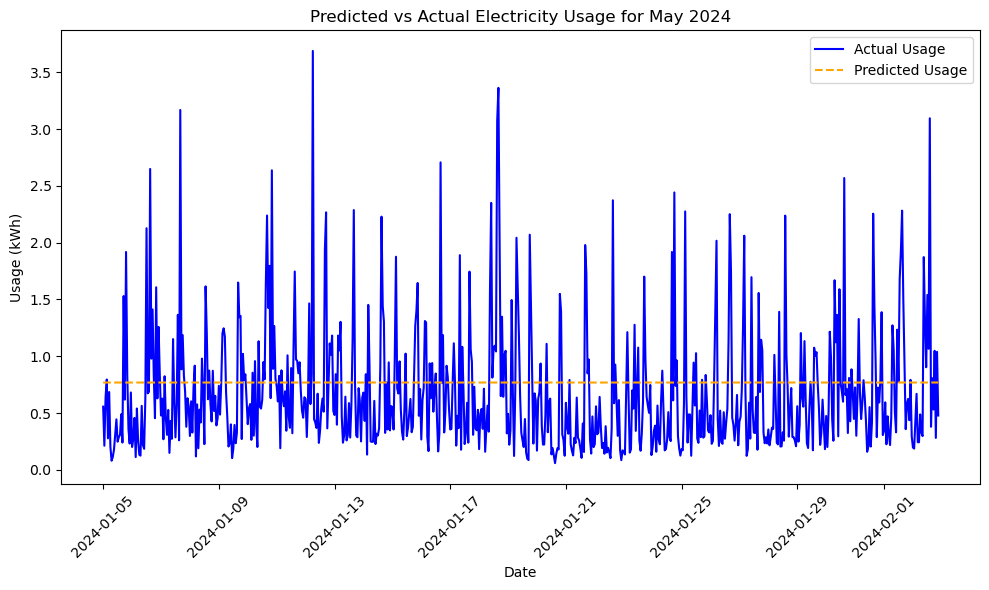

In [17]:
date_range = pd.date_range(
    start='01.05.2024', periods=len(actual_usage), freq='h')

plt.figure(figsize=(10, 6))
plt.plot(date_range, actual_usage, label='Actual Usage', color='blue')
plt.plot(date_range, predictions, label='Predicted Usage',
         color='orange', linestyle='--')
plt.title('Predicted vs Actual Electricity Usage for May 2024')
plt.xlabel('Date')
plt.ylabel('Usage (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()